<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Supervised Learning In-Depth: Support Vector Machines

Previously we introduced supervised machine learning.
There are many supervised learning algorithms available; here we'll go into brief detail one of the most powerful and interesting methods: **Support Vector Machines (SVMs)**.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

## Motivating Support Vector Machines

Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for **classification** or for **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

Let's show a quick example of support vector classification. First we need to create a dataset:

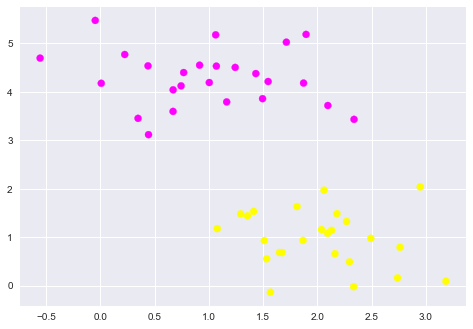

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

A discriminative classifier attempts to draw a line between the two sets of data. Immediately we see a problem: such a line is ill-posed! For example, we could come up with several possibilities which perfectly discriminate between the classes in this example:

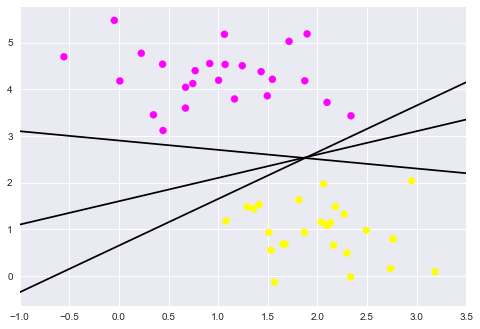

In [3]:
xfit = np.linspace(-1, 3.5)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    ax.plot(xfit, m * xfit + b, '-k')

ax.set_xlim(xmin=-1, xmax=3.5);

These are three *very* different separaters which perfectly discriminate between these samples. Depending on which you choose, a new data point will be classified almost entirely differently!

How can we improve on this?

### Support Vector Machines: Maximizing the *Margin*

Support vector machines are one way to address this.
What support vector machined do is to not only draw a line, but consider a *region* about the line of some given width.  Here's an example of what it might look like:

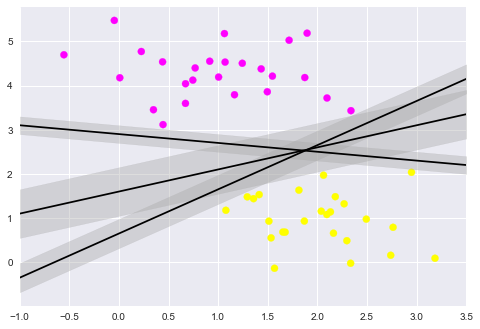

In [4]:
xfit = np.linspace(-1, 3.5)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    ax.plot(xfit, yfit, '-k')
    ax.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

ax.set_xlim(xmin=-1, xmax=3.5);

Notice here that if we want to maximize this width, the middle fit is clearly the best.
This is the intuition of **support vector machines**, which optimize a linear discriminant model in conjunction with a **margin** representing the perpendicular distance between the datasets.

#### Fitting a Support Vector Machine

Now we'll fit a Support Vector Machine Classifier to these points. While the mathematical details of the likelihood model are interesting, we'll let you read about those elsewhere. Instead, we'll just treat the scikit-learn algorithm as a black box which accomplishes the above task.

In [5]:
from sklearn.svm import SVC  # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

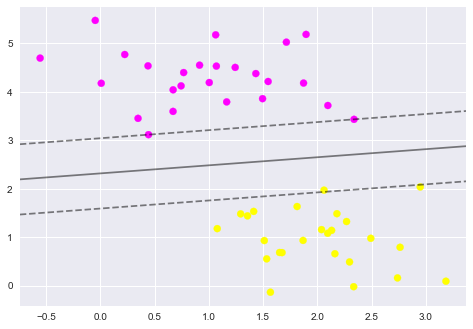

In [7]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf, ax=ax);

Notice that the dashed lines touch a couple of the points: these points are the pivotal pieces of this fit, and are known as the *support vectors* (giving the algorithm its name).
In scikit-learn, these are stored in the ``support_vectors_`` attribute of the classifier:

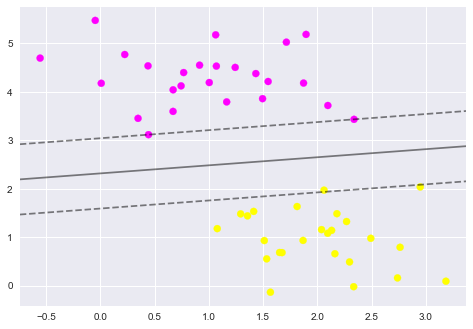

In [8]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf, ax=ax)
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Let's use IPython's ``interact`` functionality to explore how the distribution of points affects the support vectors and the discriminative fit.
(This is only available in IPython 2.0+, and will not work in a static view)

In [9]:
from ipywidgets import interact

def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    ax.set_xlim(xmin=-1, xmax=4)
    ax.set_ylim(ymin=-1, ymax=6)
    plot_svc_decision_function(clf, plt.gca())
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200]);

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

Notice the unique thing about SVM is that only the support vectors matter: that is, if you moved any of the other points without letting them cross the decision boundaries, they would have no effect on the classification results!

#### Going further: Kernel Methods

Where SVM gets incredibly exciting is when it is used in conjunction with *kernels*.
To motivate the need for kernels, let's look at some data which is not linearly separable:

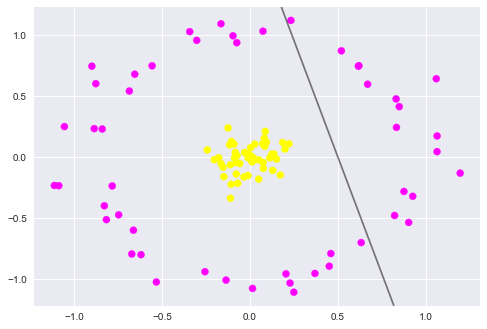

In [10]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf, ax=ax);

Clearly, no linear discrimination will ever separate these data.
One way we can adjust this is to apply a **kernel**, which is some functional transformation of the input data.

For example, one simple model we could use is a **radial basis function**

In [11]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

If we plot this along with our data, we can see the effect of it:

In [12]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azip=(-180, 180));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

We can see that with this additional dimension, the data becomes trivially linearly separable!
This is a relatively simple kernel; SVM has a more sophisticated version of this kernel built-in to the process. This is accomplished by using ``kernel='rbf'``, short for *radial basis function*:

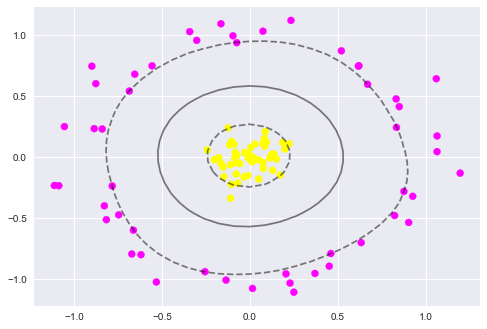

In [13]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf, ax=ax)
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Here there are effectively $N$ basis functions: one centered at each point! Through a clever mathematical trick, this computation proceeds very efficiently using the "Kernel Trick", without actually constructing the matrix of kernel evaluations.

We'll leave SVMs for the time being and take a look at another classification algorithm: Random Forests.